#  Entrenamiento, Optimización de Umbral y Evaluación
Este cuaderno ahora permite usar **data/processed/clean_for_model.csv** si existe y activas `USE_PROCESSED`.
Si no, podrás alternar entre el **sample** incluido o tu CSV real.
- Guarda: `models/model_comparison.csv`, `models/best_scored_with_cost.csv`.
- (Opcional) `models/trained_model.pkl` + `models/model_config.yaml`.


In [1]:

# --- Bootstrap del proyecto ---
import sys, pathlib, importlib, sklearn, numpy as np, pandas as pd, matplotlib
from pathlib import Path

ROOT = Path.cwd()
for cand in [ROOT] + list(ROOT.parents):
    if (cand / "src").is_dir():
        if str(cand) not in sys.path: sys.path.insert(0, str(cand))
        if str(cand / "src") not in sys.path: sys.path.insert(0, str(cand / "src"))
        break

print("Repo root:", cand)
print("sklearn version (debe ser 1.5.1):", sklearn.__version__)
print("numpy:", np.__version__, "pandas:", pd.__version__, "matplotlib:", matplotlib.__version__)

import src.runtime_transforms  # noqa


Repo root: c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN
sklearn version (debe ser 1.5.1): 1.5.1
numpy: 2.1.3 pandas: 2.3.2 matplotlib: 3.10.6


In [2]:

# Selección de datos: prioriza el dataset procesado si así lo indicas y existe
from pathlib import Path
USE_PROCESSED = True   # <- pon True para usar data/processed/clean_for_model.csv si existe
USE_SAMPLE = False      # si USE_PROCESSED es False/no existe, alterna entre SAMPLE o tu CSV
PROCESSED = Path("data/processed/clean_for_model.csv")
SAMPLE = Path("data/samples/synthetic_sample.csv")
USER_CSV = Path("../data/quejas-clientes.csv")  # ajusta si deseas

if USE_PROCESSED and PROCESSED.exists():
    CSV_PATH = PROCESSED
    print("Usando CSV PROCESADO:", CSV_PATH.resolve())
else:
    CSV_PATH = SAMPLE if USE_SAMPLE else USER_CSV
    print("Usando CSV:", CSV_PATH.resolve(), "(processed no disponible o USE_PROCESSED=False)")

df = pd.read_csv(CSV_PATH, low_memory=False)
print("Shape:", df.shape); df.head(3)


Usando CSV PROCESADO: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\notebooks\data\processed\clean_for_model.csv
Shape: (28156, 18)


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?,y,days_to_forward,Date received_year,Date received_month,Date received_dow
0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN,1,0.0,2015,3,3
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN,1,0.0,2015,3,3
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes,1,0.0,2015,3,3


In [4]:

# Target y split (detecta 'Timely response?' o 'y')
from src.preprocessing import yes_no_to_int
from sklearn.model_selection import StratifiedShuffleSplit

if "Timely response?" in df.columns:
    y_ser = yes_no_to_int(df["Timely response?"]).astype("Int64")
elif "y" in df.columns:
    y_ser = pd.Series(df["y"]).astype("Int64")
else:
    raise ValueError("No encuentro ni 'Timely response?' ni 'y' en el CSV")

mask = y_ser.notna()
df = df.loc[mask].reset_index(drop=True)
y = y_ser.loc[mask].astype(int).to_numpy()
print("Dataset usable:", df.shape, "positives(Yes):", int(y.sum()))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train, test = next(sss.split(df, y))
Xtrain, Xtest, ytrain, ytest = df.iloc[train], df.iloc[test], y[train], y[test]
Xtrain.shape, Xtest.shape


Dataset usable: (28156, 18) positives(Yes): 27444


((22524, 18), (5632, 18))

In [5]:

from src.training import build_models_and_grids, fit_grids
models = build_models_and_grids(k_best=10000)
print("Modelos en la comparativa:", list(models.keys()))

gs_dict = fit_grids(Xtrain, ytrain, models, scoring="balanced_accuracy", cv_splits=5, n_jobs=-1, verbose=1)
{ k: v.best_score_ for k, v in gs_dict.items() }


Modelos en la comparativa: ['reg_log', 'linsvm', 'svm', 'rand_forest']
Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


{'reg_log': np.float64(0.8159277443799755),
 'linsvm': np.float64(0.7429402737684474),
 'svm': np.float64(0.7337016511878077),
 'rand_forest': np.float64(0.6384039823876723)}

In [24]:
# === Guardar TODOS los modelos, grids y resultados de CV ===
from pathlib import Path
import json, yaml, joblib
import pandas as pd
import numpy as np

# Asegura que las funciones de FunctionTransformer están importables al cargar:
import src.runtime_transforms  # <- MUY IMPORTANTE para unpickling de pipelines

# Usa tus nombres reales de holdout:
# Si tus variables se llaman Xte,yte:
Xval, yval = Xtest, ytest  # o Xte, yte si es tu caso

from src.evaluation import _scores_from_estimator, sweep_threshold_for_F1_no, summarize_at_threshold

out_dir = Path("models/model_zoo")
out_dir.mkdir(parents=True, exist_ok=True)

registry = {}  # para el resumen maestro

for name, gs in gs_dict.items():
    # 1) Guardar el GridSearch completo
    pkl_gs = out_dir / f"gridsearch_{name}.pkl"
    joblib.dump(gs, pkl_gs, compress=3)

    # 2) Guardar el best_estimator_ (pipeline final)
    best_est = gs.best_estimator_
    pkl_best = out_dir / f"best_{name}.pkl"
    joblib.dump(best_est, pkl_best, compress=3)

    # 3) Guardar los resultados de CV (cv_results_) a CSV
    cv_csv = out_dir / f"cv_results_{name}.csv"
    pd.DataFrame(gs.cv_results_).to_csv(cv_csv, index=False)

    # 4) Calcular umbral óptimo en el HOLDOUT para F1_No
    scores = _scores_from_estimator(best_est, Xval)
    df_thr = sweep_threshold_for_F1_no(yval, scores, n_grid=201)  # un barrido fino
    thr_opt = float(df_thr.iloc[0]["threshold"]) if len(df_thr) else 0.5
    # Métricas al umbral óptimo y @0.5 (opcional)
    summ_opt, cm_opt = summarize_at_threshold(yval, scores, thr=thr_opt)
    summ_05,  cm_05  = summarize_at_threshold(yval, scores, thr=0.5)

    # 5) Guardar un pequeño YAML con el umbral recomendado y los params ganadores
    meta_yaml = out_dir / f"{name}_meta.yaml"
    meta = {
        "model_name": name,
        "best_score_cv": float(gs.best_score_),
        "best_params": gs.best_params_,
        "threshold_opt_f1_no": thr_opt,
        "metrics@opt": summ_opt,
        "metrics@0.5": summ_05,
        "artifacts": {
            "gridsearch_pkl": str(pkl_gs),
            "best_estimator_pkl": str(pkl_best),
            "cv_results_csv": str(cv_csv),
        },
    }
    with open(meta_yaml, "w", encoding="utf-8") as f:
        yaml.dump(meta, f, sort_keys=False, allow_unicode=True)

    # 6) Actualiza el registro maestro
    registry[name] = meta

# 7) Guarda un índice master (JSON + YAML)
master_json = out_dir / "MODEL_REGISTRY.json"
master_yaml = out_dir / "MODEL_REGISTRY.yaml"
master_json.write_text(json.dumps(registry, indent=2), encoding="utf-8")
with open(master_yaml, "w", encoding="utf-8") as f:
    yaml.dump(registry, f, sort_keys=False, allow_unicode=True)

print("Guardado completo en:", out_dir.resolve())


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is depre

Guardado completo en: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\notebooks\models\model_zoo


In [25]:
import joblib, sys
from pathlib import Path
# MUY IMPORTANTE: registrar funciones para FunctionTransformer
import src.runtime_transforms  # noqa

best_linsvm = joblib.load("models/model_zoo/best_linsvm.pkl")
gs_linsvm   = joblib.load("models/model_zoo/gridsearch_linsvm.pkl")

# Leer el umbral recomendado
import yaml
meta = yaml.safe_load(open("models/model_zoo/linsvm_meta.yaml", "r", encoding="utf-8"))
thr = float(meta["threshold_opt_f1_no"])
print("Umbral recomendado (F1_No):", thr)

Umbral recomendado (F1_No): 0.2143168203491946


In [26]:
# Guarda TODOS los GridSearchCV y artefactos por modelo
import sys, json, yaml, time, sklearn
from pathlib import Path
import joblib, pandas as pd

# Asegura que las funciones de FunctionTransformer son importables cuando cargues
import sys, pathlib
ROOT = pathlib.Path.cwd()
for cand in [ROOT] + list(ROOT.parents):
    if (cand / "src").is_dir():
        if str(cand) not in sys.path: sys.path.insert(0, str(cand))
        if str(cand / "src") not in sys.path: sys.path.insert(0, str(cand / "src"))
        break
import src.runtime_transforms  # <-- importante para deserializar luego

def save_all_grids(gs_dict, out_dir="models/all", compress=3, save_cv=True, save_best=True):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    index = {
        "created": time.strftime("%Y-%m-%d %H:%M:%S"),
        "sklearn_version": sklearn.__version__,
        "artifacts": []
    }
    for name, gs in gs_dict.items():
        # 1) GridSearchCV completo
        grid_path = out_dir / f"grid_{name}.pkl"
        joblib.dump(gs, grid_path, compress=compress)

        art = {"name": name, "gridsearch": str(grid_path)}

        # 2) Mejor estimador + params
        if save_best:
            best_path = out_dir / f"best_{name}.pkl"
            joblib.dump(gs.best_estimator_, best_path, compress=compress)
            params_path = out_dir / f"best_params_{name}.yaml"
            with params_path.open("w", encoding="utf-8") as f:
                yaml.safe_dump(
                    {"best_params": gs.best_params_, "best_cv_score": float(gs.best_score_)},
                    f, sort_keys=False, allow_unicode=True
                )
            art.update({"best_estimator": str(best_path), "best_params_yaml": str(params_path)})

        # 3) cv_results_ a CSV
        if save_cv:
            cv_path = out_dir / f"cv_results_{name}.csv"
            pd.DataFrame(gs.cv_results_).to_csv(cv_path, index=False)
            art["cv_results_csv"] = str(cv_path)

        index["artifacts"].append(art)

    idx_path = out_dir / "INDEX.json"
    idx_path.write_text(json.dumps(index, indent=2), encoding="utf-8")
    print(f"✅ Guardado todo en: {out_dir.resolve()}")
    return index



In [17]:
import importlib, src.evaluation as evaluation
evaluation = importlib.reload(evaluation)
from src.evaluation import evaluate_best

In [27]:
import numpy as np
import pandas as pd
from src.evaluation import sweep_threshold_for_F1_no, summarize_at_threshold

def _scores_from_estimator(estimator, X):
    # Igual que en evaluation.py
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:,1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
    else:
        s = estimator.predict(X).astype(float)
    smin, smax = float(np.min(s)), float(np.max(s))
    return (s - smin) / (smax - smin + 1e-9)

def save_all_with_threshold(gs_dict, Xtest, ytest, out_dir="models/all_with_thr", compress=3):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    summary_rows = []
    for name, gs in gs_dict.items():
        est = gs.best_estimator_
        scores = _scores_from_estimator(est, Xtest)
        df_thr = sweep_threshold_for_F1_no(ytest, scores, n_grid=101)
        thr_opt = float(df_thr.iloc[0]["threshold"])
        # métricas en thr óptimo
        summ_opt, cm_opt = summarize_at_threshold(ytest, scores, thr=thr_opt)

        # Guardar YAML por modelo con umbral y métricas clave
        yml = {
            "model_name": name,
            "best_cv_score": float(gs.best_score_),
            "threshold_opt_f1_no": thr_opt,
            "metrics_at_opt": {
                "roc_auc": float(summ_opt["roc_auc"]),
                "pr_auc": float(summ_opt["pr_auc"]),
                "f1_no": float(summ_opt["f1_no"]),
                "f1_yes": float(summ_opt["f1_yes"]),
                "balanced_acc": float(summ_opt["balanced_acc"]),
                "confusion_matrix_rows_true_0_1_cols_pred_0_1": cm_opt.tolist(),
            },
            "best_params": gs.best_params_,
        }
        yml_path = out_dir / f"threshold_and_metrics_{name}.yaml"
        with yml_path.open("w", encoding="utf-8") as f:
            yaml.safe_dump(yml, f, sort_keys=False, allow_unicode=True)

        # Guarda best estimator y grid (por si no lo hiciste arriba)
        joblib.dump(gs, out_dir / f"grid_{name}.pkl", compress=compress)
        joblib.dump(est, out_dir / f"best_{name}.pkl", compress=compress)

        summary_rows.append({
            "modelo": name,
            "best_cv_score": float(gs.best_score_),
            "thr_opt": thr_opt,
            "F1_No@opt": float(summ_opt["f1_no"]),
            "BalAcc@opt": float(summ_opt["balanced_acc"]),
            "ROC_AUC": float(summ_opt["roc_auc"]),
            "PR_AUC": float(summ_opt["pr_auc"]),
        })

    # CSV resumen global
    df_summary = pd.DataFrame(summary_rows).sort_values(["F1_No@opt","BalAcc@opt"], ascending=[False,False])
    df_summary.to_csv(out_dir / "SUMMARY_all_models_with_thresholds.csv", index=False)
    print(f"✅ Guardado todo (incluye umbrales) en: {out_dir.resolve()}")
    return df_summary




c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:46: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d0 = pd.to_datetime(s_start, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and 

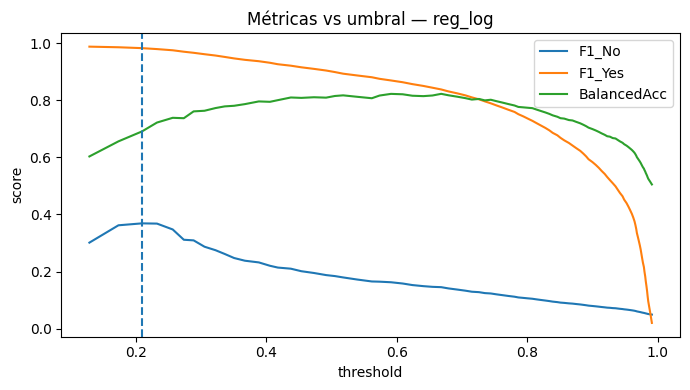

<Figure size 600x500 with 0 Axes>

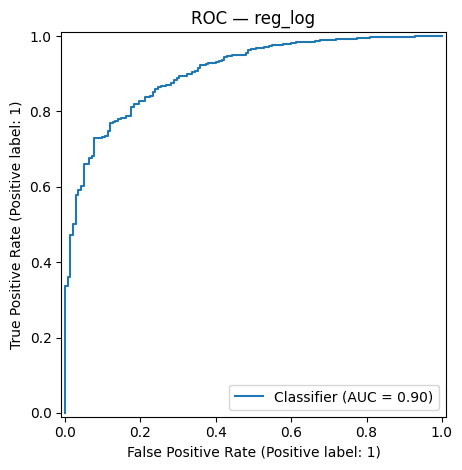

<Figure size 600x500 with 0 Axes>

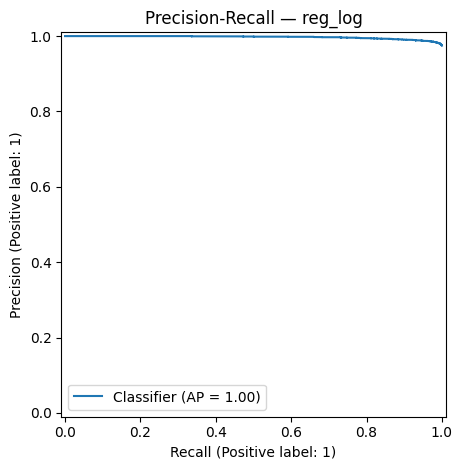

c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:46: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d0 = pd.to_datetime(s_start, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and 

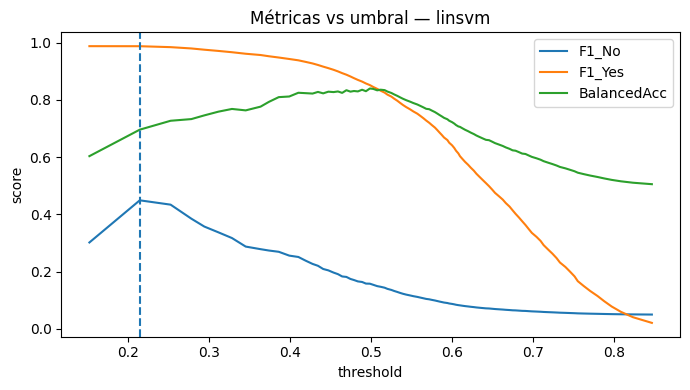

<Figure size 600x500 with 0 Axes>

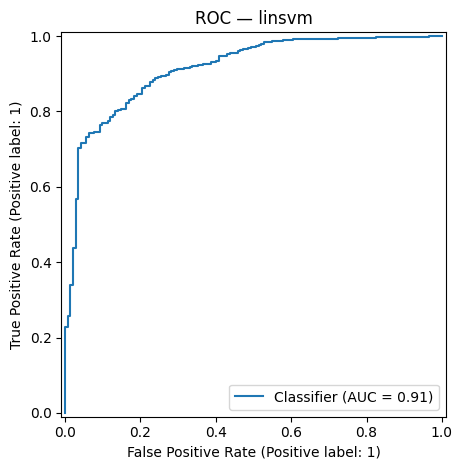

<Figure size 600x500 with 0 Axes>

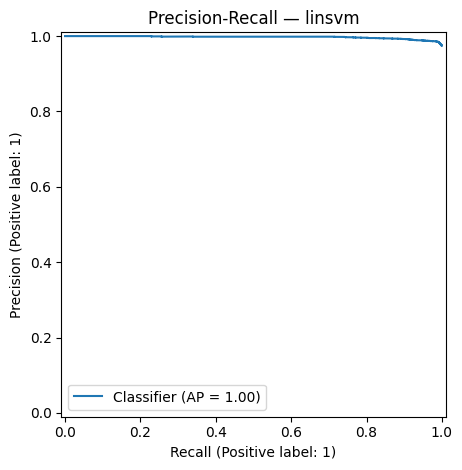

c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:46: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d0 = pd.to_datetime(s_start, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and 

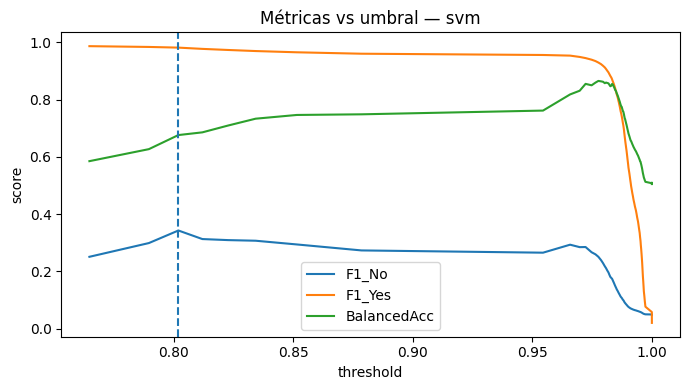

<Figure size 600x500 with 0 Axes>

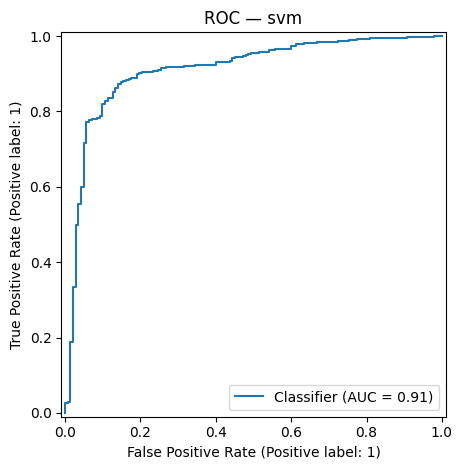

<Figure size 600x500 with 0 Axes>

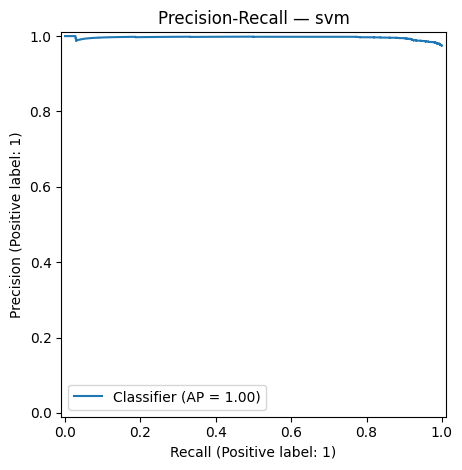

c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:46: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d0 = pd.to_datetime(s_start, errors="coerce", infer_datetime_format=True)
C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\evaluation.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and 

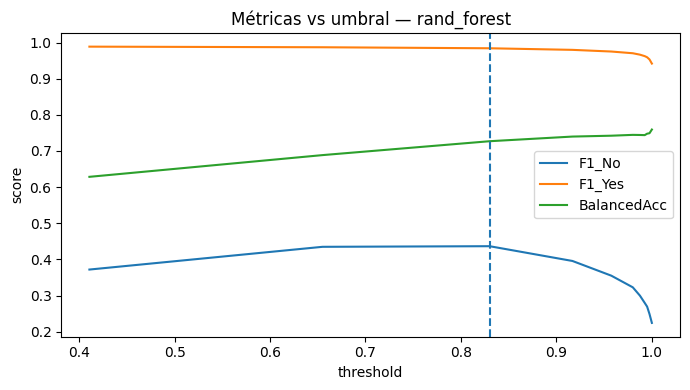

<Figure size 600x500 with 0 Axes>

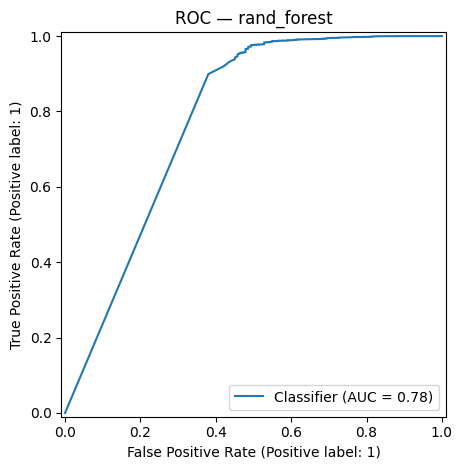

<Figure size 600x500 with 0 Axes>

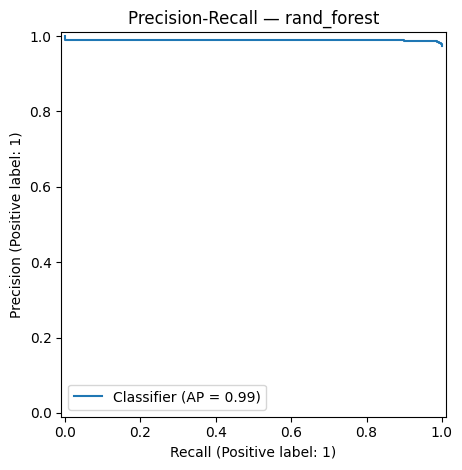

,modelo,GS_best_cv_score,ROC_AUC,PR_AUC,F1_No@0.5,BalAcc@0.5,F1_No@opt,BalAcc@opt,thr_opt,avg_expected_cost@opt
0,linsvm,0.742940,0.914210,0.997254,0.155920,0.837982,0.448819,0.695695,0.214317,7.433841
1,rand_forest,0.638404,0.780151,0.988948,0.400000,0.648676,0.436482,0.726990,0.830000,4.154045
2,reg_log,0.815928,0.904322,0.997068,0.185819,0.812975,0.368932,0.690686,0.209649,5.997179
3,svm,0.733702,0.911325,0.996383,0.013986,0.503521,0.343042,0.676237,0.802045,4.226026


In [18]:

#from src.evaluation import evaluate_best
comp, details = evaluate_best(gs_dict, Xtest, ytest, df.loc[test])
comp


In [19]:

from pathlib import Path
out_cmp = Path("models/model_comparison.csv"); out_cmp.parent.mkdir(parents=True, exist_ok=True)
comp.to_csv(out_cmp, index=False)
print("Guardado:", out_cmp.resolve())


Guardado: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\notebooks\models\model_comparison.csv


In [20]:

best_name = comp.iloc[0]["modelo"]
enriched = details[best_name]["enriched_df"]
out_scores = Path("models/best_scored_with_cost.csv")
enriched.to_csv(out_scores, index=False)
print("Guardado:", out_scores.resolve(), "filas:", len(enriched))
enriched.head(3)


Guardado: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\notebooks\models\best_scored_with_cost.csv filas: 5632


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,...,y,days_to_forward,Date received_year,Date received_month,Date received_dow,p_yes,p_no,pred,expected_cost,high_cost_flag
2064,1268527,Credit reporting,NaN,Incorrect information on credit report,Account status,FL,34759.0,2015-03-04,2015-03-04,Equifax,...,1,0.0,2015,3,2,0.689730,0.310270,1,3.482163,0
22428,1196206,Debt collection,Payday loan,Communication tactics,Frequent or repeated calls,CO,80910.0,2015-01-15,2015-01-15,Pacific Rim Alliance Corporation,...,1,0.0,2015,1,3,0.403435,0.596565,1,5.772519,0
8508,1242211,Credit reporting,NaN,Incorrect information on credit report,Account status,TX,76226.0,2015-02-17,2015-02-17,Experian,...,1,0.0,2015,2,1,0.628986,0.371014,1,3.968115,0


In [21]:

from src.training import train_and_save_best
res = train_and_save_best(df, y, models, test_size=0.2, random_state=42,
                          out_model=Path("models/trained_model.pkl"),
                          out_config=Path("models/model_config.yaml"))
res


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'i

{'best_model': 'linsvm',
 'f1_no_val': 0.44881889763779526,
 'threshold': 0.2143168203491946,
 'out_model': 'models\\trained_model.pkl',
 'out_config': 'models\\model_config.yaml'}

In [2]:
# --- ENTRENAMIENTO sin subprocess (Windows-friendly) ---
import sys, runpy
from pathlib import Path

# Detecta raíz del repo (carpeta que contiene 'src')
repo_root = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists())
sys.path.insert(0, str(repo_root))  # para poder importar 'src.*'

CSV = repo_root / "data" / "processed" / "clean_for_model.csv"
assert CSV.exists(), f"No existe {CSV}. Ejecuta primero la limpieza y guardado del dataset."

# IMPORTANTE: en sys.argv NO va '-m src.train_cli'. Solo los argumentos reales:
sys.argv = [
    "train_cli",  # nombre del prog (cualquier string)
    "--data", str(CSV),
    "--out-model", str(repo_root / "models" / "trained_model_cli.pkl"),
    "--out-config", str(repo_root / "models" / "model_config_cli.yaml"),
]

# Ejecuta el módulo como si fuera 'python -m src.train_cli'
runpy.run_module("src.train_cli", run_name="__main__")

print("✔ Entrenamiento completado.")
print("Modelo:", (repo_root / "models" / "trained_model_cli.pkl").resolve())
print("Config:", (repo_root / "models" / "model_config_cli.yaml").resolve())


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2153. All the features will be returned.
  warnings.warn(
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can sa

{
  "best_model": "linsvm",
  "f1_no_val": 0.44881889763779526,
  "threshold": 0.2143168203491946,
  "out_model": "c:\\Users\\abela\\Downloads\\final\\Proyecto_timely_response_CLEAN\\models\\trained_model_clo.pkl",
  "out_config": "c:\\Users\\abela\\Downloads\\final\\Proyecto_timely_response_CLEAN\\models\\model_config_cli.yaml"
}
✔ Entrenamiento completado.
Modelo: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\models\trained_model_cli.pkl
Config: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\models\model_config_cli.yaml


In [4]:
# --- PREDICCIÓN sin subprocess (Windows-friendly) ---
import sys, runpy
from pathlib import Path

repo_root = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists())
sys.path.insert(0, str(repo_root))  # para poder importar 'src.*'

CSV_IN  = repo_root / "data" / "processed" / "clean_for_model.csv"
MODEL   = repo_root / "models" / "trained_model_cli.pkl"
CONFIG  = repo_root / "models" / "model_config_cli.yaml"
OUT_CSV = repo_root / "models" / "scored_cli.csv"

for p in (CSV_IN, MODEL, CONFIG):
    assert p.exists(), f"Falta {p}"

# IMPORTANTE: tampoco aquí va '-m src.predict_cli' en sys.argv
sys.argv = [
    "predict_cli",
    "--data", str(CSV_IN),
    "--model", str(MODEL),
    "--config", str(CONFIG),
    "--out", str(OUT_CSV),
]

runpy.run_module("src.predict_cli", run_name="__main__")

import pandas as pd
scored = pd.read_csv(OUT_CSV, low_memory=False)
print("✔ Scored generado en:", OUT_CSV.resolve())
scored.head(5)

c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\runtime_transforms.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)


{
  "wrote": "c:\\Users\\abela\\Downloads\\final\\Proyecto_timely_response_CLEAN\\models\\scored_cli.csv",
  "n": 28156,
  "threshold_used": 0.2143168203491946
}
✔ Scored generado en: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\models\scored_cli.csv


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?,y,days_to_forward,Date received_year,Date received_month,Date received_dow,score,pred
0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN,1,0.0,2015,3,3,0.620756,1
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN,1,0.0,2015,3,3,0.501594,1
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes,1,0.0,2015,3,3,0.675745,1
3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,Navy FCU,In progress,Yes,NaN,1,0.0,2015,3,3,0.851485,1
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068.0,2015-03-19,2015-03-19,Transworld Systems Inc.,In progress,Yes,NaN,1,0.0,2015,3,3,0.707436,1
